In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate dataset for class 0 (1 cluster)
X0, y0 = make_classification(
    n_samples=500, n_classes=2, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=1, random_state=42, class_sep=2.0
)
y0 = np.zeros(500)  # Assign class 0

# Generate dataset for class 1 (2 clusters)
X1, y1 = make_classification(
    n_samples=500, n_classes=2, n_features=2, n_informative=2, n_redundant=0,
    n_clusters_per_class=2, random_state=42, class_sep=2.0
)
y1 = np.ones(500)  # Assign class 1

# Combine datasets
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Verify shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (800, 2), y_train shape: (800,)
X_test shape: (200, 2), y_test shape: (200,)


In [ ]:
class MLP:
    def __init__(self, input_size=2, hidden_size=10, output_size=1, lr=0.01):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))


        
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def sigmoid_derivative(self, x):
        s = self.sigmoid(x)
        return s * (1 - s)
    
    def forward(self, X):
        # Hidden layer
        self.z1 = X @ self.W1 + self.b1  # (N, hidden_size)
        self.h1 = self.relu(self.z1)      # (N, hidden_size)
        # Output layer
        self.z2 = self.h1 @ self.W2 + self.b2  # (N, output_size)
        self.y_hat = self.sigmoid(self.z2)     # (N, output_size)
        return self.y_hat
    
    def compute_loss(self, y, y_hat):
        y = y.reshape(-1, 1)
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)  # Avoid log(0)
        loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        return loss
    
    def backward(self, X, y, y_hat):
        y = y.reshape(-1, 1)
        N = X.shape[0]
        # Gradient w.r.t. output
        dL_dyhat = -(y / y_hat - (1 - y) / (1 - y_hat)) / N  # (N, 1)
        dL_dz2 = dL_dyhat * self.sigmoid_derivative(self.z2)  # (N, 1)
        # Output layer gradients
        dL_dW2 = self.h1.T @ dL_dz2  # (hidden_size, 1)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)  # (1, 1)
        # Hidden layer gradients
        dL_dh1 = dL_dz2 @ self.W2.T  # (N, hidden_size)
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)  # (N, hidden_size)
        dL_dW1 = X.T @ dL_dz1  # (input_size, hidden_size)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)  # (1, hidden_size)
        # Update parameters
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=200):
        losses = []
        for epoch in range(1, epochs + 1):
            y_hat = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            self.backward(X, y, y_hat)
            losses.append(loss)
            if epoch % 50 == 0 or epoch == epochs:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

IndexError: arrays used as indices must be of integer (or boolean) type

In [20]:
mlp = MLP(input_size=4, hidden_size=10, output_size=1, lr=0.01)
losses = mlp.train(X_train, y_train, epochs=200)

ValueError: operands could not be broadcast together with shapes (3600,1) (1200,1) 

Test Accuracy: 0.7400


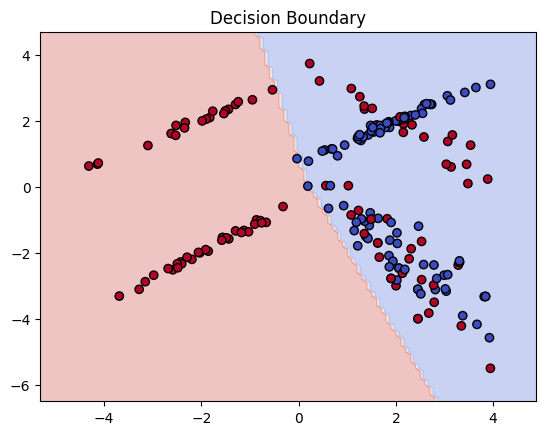

In [12]:
# Predict and compute accuracy
y_pred = mlp.forward(X_test)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
accuracy = np.mean(y_pred_binary == y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.forward(X_grid)
    Z = (Z > 0.5).astype(int).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.title('Decision Boundary')
    plt.show()

plot_decision_boundary(X_test, y_test, mlp)

Epoch 0, Loss: 1.0985
Epoch 50, Loss: 1.0984
Epoch 100, Loss: 1.0983
Epoch 150, Loss: 1.0982
Test Accuracy: 0.5067


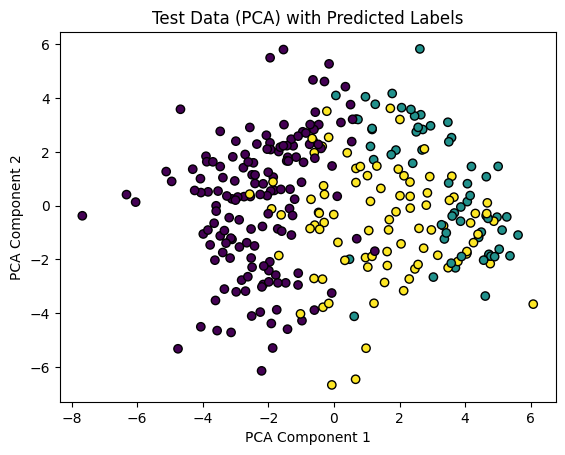

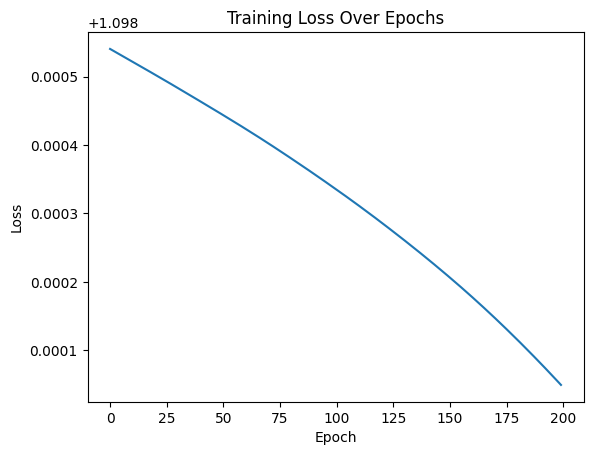

In [14]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data generation
# Class 0: 2 clusters
X0, y0 = make_classification(
    n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
    n_clusters_per_class=2, random_state=42, class_sep=2.0
)
y0 = np.zeros(500)  # Assign class 0

# Class 1: 3 clusters
X1, y1 = make_classification(
    n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
    n_clusters_per_class=3, random_state=42, class_sep=2.0
)
y1 = np.ones(500)  # Assign class 1

# Class 2: 4 clusters
X2, y2 = make_classification(
    n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
    n_clusters_per_class=4, random_state=42, class_sep=2.0
)
y2 = np.full(500, 2)  # Assign class 2

# Combine datasets
X = np.vstack((X0, X1, X2))
y = np.hstack((y0, y1, y2))

# Convert y to one-hot encoding for multi-class
y_one_hot = np.zeros((y.size, 3))
y_one_hot[np.arange(y.size), y.astype(int)] = 1

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_one_hot, test_size=0.2, random_state=42, stratify=y
)

class MLP:
    def __init__(self, input_size=4, hidden_size=10, output_size=3, lr=0.01):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        # Hidden layer
        self.z1 = X @ self.W1 + self.b1  # (N, hidden_size)
        self.h1 = self.relu(self.z1)      # (N, hidden_size)
        # Output layer
        self.z2 = self.h1 @ self.W2 + self.b2  # (N, output_size)
        self.y_hat = self.softmax(self.z2)     # (N, output_size)
        return self.y_hat
    
    def compute_loss(self, y, y_hat):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)  # Avoid log(0)
        loss = -np.mean(np.sum(y * np.log(y_hat), axis=1))
        return loss
    
    def backward(self, X, y, y_hat):
        N = X.shape[0]
        # Gradient w.r.t. output (softmax + cross-entropy simplifies to)
        dL_dz2 = (y_hat - y) / N  # (N, output_size)
        # Output layer gradients
        dL_dW2 = self.h1.T @ dL_dz2  # (hidden_size, output_size)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)  # (1, output_size)
        # Hidden layer gradients
        dL_dh1 = dL_dz2 @ self.W2.T  # (N, hidden_size)
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)  # (N, hidden_size)
        dL_dW1 = X.T @ dL_dz1  # (input_size, hidden_size)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)  # (1, hidden_size)
        # Update parameters
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=200):
        losses = []
        for epoch in range(epochs):
            y_hat = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            self.backward(X, y, y_hat)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        y_hat = self.forward(X)
        return np.argmax(y_hat, axis=1)

# Train the model
mlp = MLP(input_size=4, hidden_size=10, output_size=3, lr=0.01)
losses = mlp.train(X_train, y_train, epochs=200)

# Evaluate on test set
y_pred = mlp.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualize using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='viridis', edgecolors='k')
plt.title('Test Data (PCA) with Predicted Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot training loss
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 0, Loss: 1.0986
Epoch 50, Loss: 1.0986
Epoch 100, Loss: 1.0986
Epoch 150, Loss: 1.0986
Test Accuracy: 0.3400


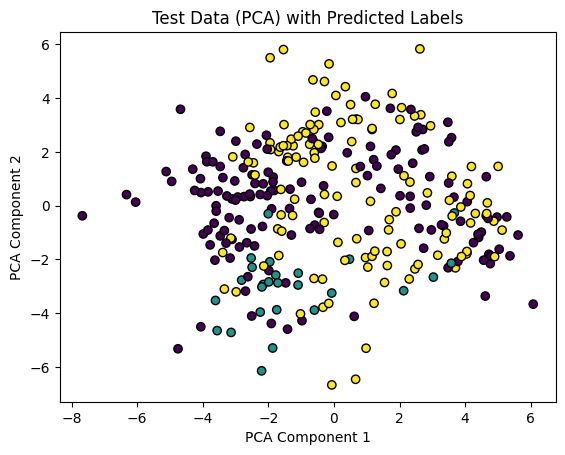

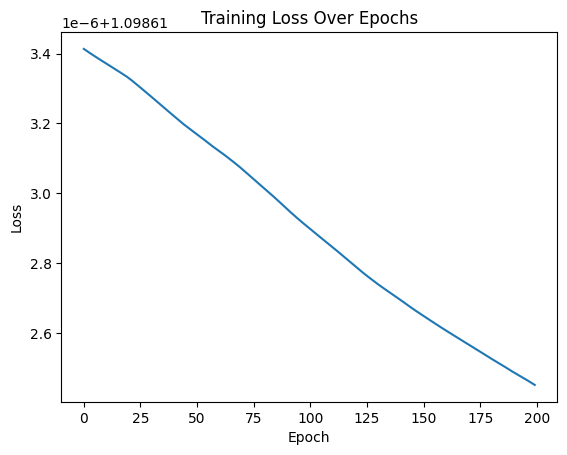

In [16]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data generation (same as Exercise 3)
X0, y0 = make_classification(
    n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
    n_clusters_per_class=2, random_state=42, class_sep=2.0
)
y0 = np.zeros(500)
X1, y1 = make_classification(
    n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
    n_clusters_per_class=3, random_state=42, class_sep=2.0
)
y1 = np.ones(500)
X2, y2 = make_classification(
    n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
    n_clusters_per_class=4, random_state=42, class_sep=2.0
)
y2 = np.full(500, 2)
X = np.vstack((X0, X1, X2))
y = np.hstack((y0, y1, y2))
y_one_hot = np.zeros((y.size, 3))
y_one_hot[np.arange(y.size), y.astype(int)] = 1
X_train, X_test, y_train, y_test = train_test_split(
    X, y_one_hot, test_size=0.2, random_state=42, stratify=y
)

class MLP:
    def __init__(self, input_size=4, hidden_size1=10, hidden_size2=8, output_size=3, lr=0.01):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size1) * 0.01
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * 0.01
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        # Hidden layer 1
        self.z1 = X @ self.W1 + self.b1  # (N, hidden_size1)
        self.h1 = self.relu(self.z1)      # (N, hidden_size1)
        # Hidden layer 2
        self.z2 = self.h1 @ self.W2 + self.b2  # (N, hidden_size2)
        self.h2 = self.relu(self.z2)      # (N, hidden_size2)
        # Output layer
        self.z3 = self.h2 @ self.W3 + self.b3  # (N, output_size)
        self.y_hat = self.softmax(self.z3)     # (N, output_size)
        return self.y_hat
    
    def compute_loss(self, y, y_hat):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        loss = -np.mean(np.sum(y * np.log(y_hat), axis=1))
        return loss
    
    def backward(self, X, y, y_hat):
        N = X.shape[0]
        # Gradient w.r.t. output
        dL_dz3 = (y_hat - y) / N  # (N, output_size)
        # Output layer gradients
        dL_dW3 = self.h2.T @ dL_dz3  # (hidden_size2, output_size)
        dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)  # (1, output_size)
        # Hidden layer 2 gradients
        dL_dh2 = dL_dz3 @ self.W3.T  # (N, hidden_size2)
        dL_dz2 = dL_dh2 * self.relu_derivative(self.z2)  # (N, hidden_size2)
        dL_dW2 = self.h1.T @ dL_dz2  # (hidden_size1, hidden_size2)
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)  # (1, hidden_size2)
        # Hidden layer 1 gradients
        dL_dh1 = dL_dz2 @ self.W2.T  # (N, hidden_size1)
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)  # (N, hidden_size1)
        dL_dW1 = X.T @ dL_dz1  # (input_size, hidden_size1)
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)  # (1, hidden_size1)
        # Update parameters
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=200):
        losses = []
        for epoch in range(epochs):
            y_hat = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            self.backward(X, y, y_hat)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        y_hat = self.forward(X)
        return np.argmax(y_hat, axis=1)

# Train the model
mlp = MLP(input_size=4, hidden_size1=10, hidden_size2=8, output_size=3, lr=0.01)
losses = mlp.train(X_train, y_train, epochs=200)

# Evaluate on test set
y_pred = mlp.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualize using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='viridis', edgecolors='k')
plt.title('Test Data (PCA) with Predicted Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Plot training loss
plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 0, Loss: 1.3037
Epoch 50, Loss: 0.6429
Epoch 100, Loss: 0.5682
Epoch 150, Loss: 0.5304
Epoch 200, Loss: 0.5020
Epoch 250, Loss: 0.4794
Epoch 300, Loss: 0.4603
Epoch 350, Loss: 0.4441
Epoch 400, Loss: 0.4297
Epoch 450, Loss: 0.4175
Test Accuracy: 0.7700


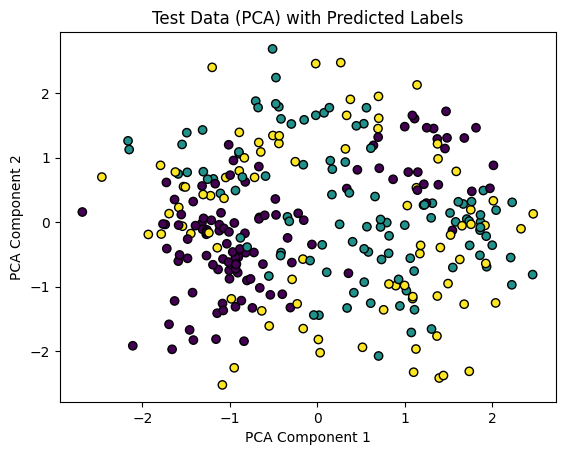

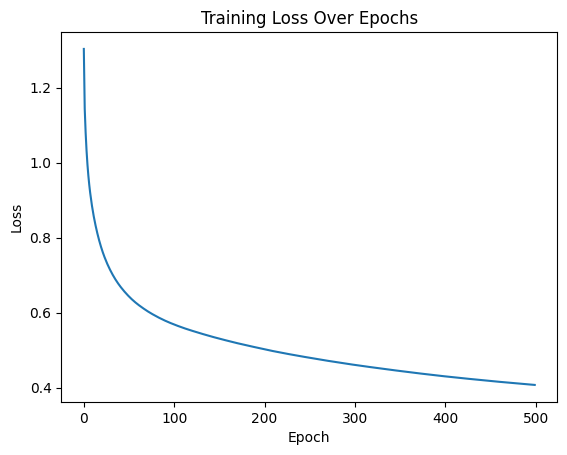

In [22]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data generation
X0, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=2, random_state=42, class_sep=2.0)
y0 = np.zeros(500)
X1, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=3, random_state=43, class_sep=2.0)
y1 = np.ones(500)
X2, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=4, random_state=44, class_sep=2.0)
y2 = np.full(500, 2)
X = np.vstack((X0, X1, X2))
y = np.hstack((y0, y1, y2))
y_one_hot = np.zeros((y.size, 3))
y_one_hot[np.arange(y.size), y.astype(int)] = 1

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

class MLP:
    def __init__(self, input_size=4, hidden_size1=64, hidden_size2=32, output_size=3, lr=0.1):
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size1) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size1))
        self.W2 = np.random.randn(hidden_size1, hidden_size2) * np.sqrt(2 / hidden_size1)
        self.b2 = np.zeros((1, hidden_size2))
        self.W3 = np.random.randn(hidden_size2, output_size) * np.sqrt(2 / hidden_size2)
        self.b3 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        self.z2 = self.h1 @ self.W2 + self.b2
        self.h2 = self.relu(self.z2)
        self.z3 = self.h2 @ self.W3 + self.b3
        self.y_hat = self.softmax(self.z3)
        return self.y_hat
    
    def compute_loss(self, y, y_hat):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        return -np.mean(np.sum(y * np.log(y_hat), axis=1))
    
    def backward(self, X, y, y_hat):
        N = X.shape[0]
        dL_dz3 = (y_hat - y) / N
        dL_dW3 = self.h2.T @ dL_dz3
        dL_db3 = np.sum(dL_dz3, axis=0, keepdims=True)
        dL_dh2 = dL_dz3 @ self.W3.T
        dL_dz2 = dL_dh2 * self.relu_derivative(self.z2)
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        dL_dW1 = X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        # Gradient clipping
        max_grad = 1.0
        dL_dW1 = np.clip(dL_dW1, -max_grad, max_grad)
        dL_dW2 = np.clip(dL_dW2, -max_grad, max_grad)
        dL_dW3 = np.clip(dL_dW3, -max_grad, max_grad)
        # Update parameters
        self.W3 -= self.lr * dL_dW3
        self.b3 -= self.lr * dL_db3
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=500):
        losses = []
        for epoch in range(epochs):
            y_hat = self.forward(X)
            loss = self.compute_loss(y, y_hat)
            self.backward(X, y, y_hat)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X):
        y_hat = self.forward(X)
        return np.argmax(y_hat, axis=1)

# Train and evaluate
mlp = MLP(input_size=4, hidden_size1=64, hidden_size2=32, output_size=3, lr=0.1)
losses = mlp.train(X_train, y_train, epochs=500)
y_pred = mlp.predict(X_test)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualizations
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='viridis', edgecolors='k')
plt.title('Test Data (PCA) with Predicted Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 0, Loss: 1.6466
Epoch 50, Loss: 0.7559
Epoch 100, Loss: 0.6809
Epoch 150, Loss: 0.6460
Epoch 200, Loss: 0.6245
Epoch 250, Loss: 0.6093
Epoch 300, Loss: 0.5970
Epoch 350, Loss: 0.5866
Epoch 400, Loss: 0.5773
Epoch 450, Loss: 0.5691
Test Accuracy: 0.6867


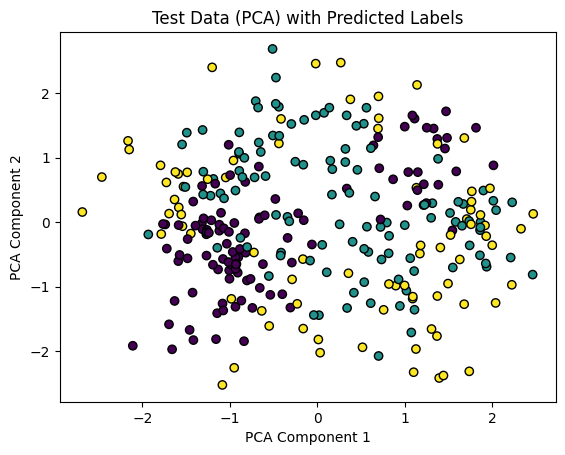

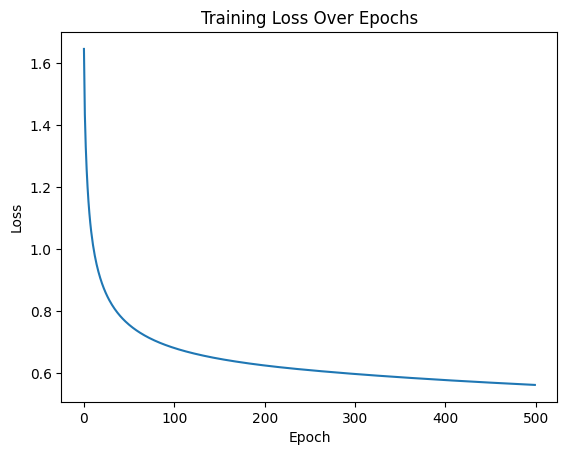

In [24]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Data generation for Exercise 3
X0, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=2, random_state=42, class_sep=2.0)
y0 = np.zeros(500)
X1, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=3, random_state=43, class_sep=2.0)
y1 = np.ones(500)
X2, _ = make_classification(n_samples=500, n_classes=2, n_features=4, n_informative=4, n_redundant=0,
                           n_clusters_per_class=4, random_state=44, class_sep=2.0)
y2 = np.full(500, 2)
X = np.vstack((X0, X1, X2))
y = np.hstack((y0, y1, y2))
y_one_hot = np.zeros((y.size, 3))
y_one_hot[np.arange(y.size), y.astype(int)] = 1

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y)

# MLP class reused from Exercise 2
class MLP:
    def __init__(self, input_size=4, hidden_size=64, output_size=3, lr=0.1):
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X, is_binary=False):
        # Hidden layer
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        # Output layer
        self.z2 = self.h1 @ self.W2 + self.b2
        if is_binary:
            self.y_hat = self.sigmoid(self.z2)
        else:
            self.y_hat = self.softmax(self.z2)
        return self.y_hat
    
    def compute_loss(self, y, y_hat, is_binary=False):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        if is_binary:
            return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        else:
            return -np.mean(np.sum(y * np.log(y_hat), axis=1))
    
    def backward(self, X, y, y_hat, is_binary=False):
        N = X.shape[0]
        if is_binary:
            dL_dz2 = (y_hat - y) / N
        else:
            dL_dz2 = (y_hat - y) / N
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        dL_dW1 = X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        # Gradient clipping
        max_grad = 1.0
        dL_dW1 = np.clip(dL_dW1, -max_grad, max_grad)
        dL_dW2 = np.clip(dL_dW2, -max_grad, max_grad)
        # Update parameters
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=500, is_binary=False):
        losses = []
        for epoch in range(epochs):
            y_hat = self.forward(X, is_binary)
            loss = self.compute_loss(y, y_hat, is_binary)
            self.backward(X, y, y_hat, is_binary)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X, is_binary=False):
        y_hat = self.forward(X, is_binary)
        if is_binary:
            return (y_hat >= 0.5).astype(int).flatten()
        else:
            return np.argmax(y_hat, axis=1)

# Train and evaluate for Exercise 3 (multi-class)
mlp = MLP(input_size=4, hidden_size=64, output_size=3, lr=0.1)
losses = mlp.train(X_train, y_train, epochs=500, is_binary=False)
y_pred = mlp.predict(X_test, is_binary=False)
y_test_labels = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_test_labels)
print(f"Test Accuracy: {accuracy:.4f}")

# Visualizations
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test)
plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=y_pred, cmap='viridis', edgecolors='k')
plt.title('Test Data (PCA) with Predicted Labels')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Epoch 0, Loss: 0.8533
Epoch 50, Loss: 0.4888
Epoch 100, Loss: 0.4792
Epoch 150, Loss: 0.4734
Epoch 200, Loss: 0.4690
Epoch 250, Loss: 0.4652
Epoch 300, Loss: 0.4616
Epoch 350, Loss: 0.4581
Epoch 400, Loss: 0.4545
Epoch 450, Loss: 0.4508
Test Accuracy: 0.7250


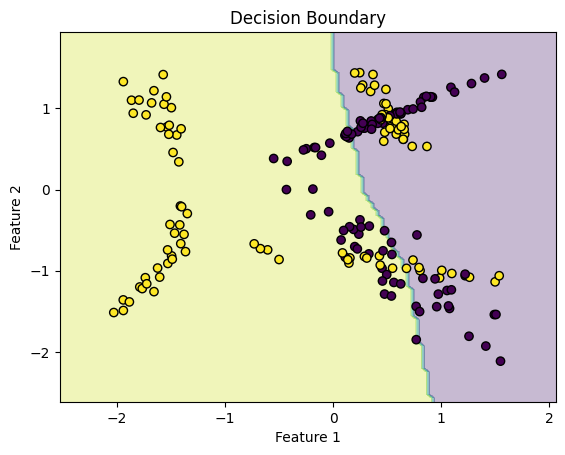

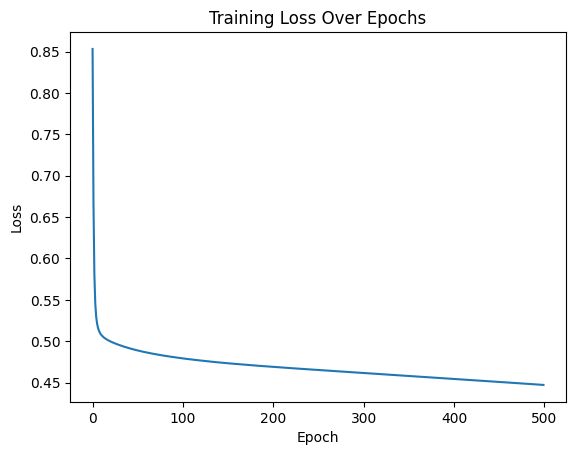

In [25]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Data generation for Exercise 2
X0, y0 = make_classification(n_samples=500, n_classes=2, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=1, random_state=42, class_sep=2.0)
y0 = np.zeros(500)  # Class 0 with 1 cluster
X1, y1 = make_classification(n_samples=500, n_classes=2, n_features=2, n_informative=2, n_redundant=0,
                            n_clusters_per_class=2, random_state=43, class_sep=2.0)
y1 = np.ones(500)  # Class 1 with 2 clusters
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train = y_train.reshape(-1, 1)  # Reshape for binary classification
y_test = y_test.reshape(-1, 1)

# MLP class for Exercise 2 (reusable for Exercise 3)
class MLP:
    def __init__(self, input_size=2, hidden_size=64, output_size=1, lr=0.1):
        # He initialization
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2 / hidden_size)
        self.b2 = np.zeros((1, output_size))
        self.lr = lr

    def relu(self, x):
        return np.maximum(0, x)
    
    def relu_derivative(self, x):
        return np.where(x > 0, 1, 0)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, X, is_binary=True):
        # Hidden layer
        self.z1 = X @ self.W1 + self.b1
        self.h1 = self.relu(self.z1)
        # Output layer
        self.z2 = self.h1 @ self.W2 + self.b2
        if is_binary:
            self.y_hat = self.sigmoid(self.z2)
        else:
            self.y_hat = self.softmax(self.z2)
        return self.y_hat
    
    def compute_loss(self, y, y_hat, is_binary=True):
        y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
        if is_binary:
            return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        else:
            return -np.mean(np.sum(y * np.log(y_hat), axis=1))
    
    def backward(self, X, y, y_hat, is_binary=True):
        N = X.shape[0]
        if is_binary:
            dL_dz2 = (y_hat - y) / N
        else:
            dL_dz2 = (y_hat - y) / N
        dL_dW2 = self.h1.T @ dL_dz2
        dL_db2 = np.sum(dL_dz2, axis=0, keepdims=True)
        dL_dh1 = dL_dz2 @ self.W2.T
        dL_dz1 = dL_dh1 * self.relu_derivative(self.z1)
        dL_dW1 = X.T @ dL_dz1
        dL_db1 = np.sum(dL_dz1, axis=0, keepdims=True)
        # Gradient clipping
        max_grad = 1.0
        dL_dW1 = np.clip(dL_dW1, -max_grad, max_grad)
        dL_dW2 = np.clip(dL_dW2, -max_grad, max_grad)
        # Update parameters
        self.W2 -= self.lr * dL_dW2
        self.b2 -= self.lr * dL_db2
        self.W1 -= self.lr * dL_dW1
        self.b1 -= self.lr * dL_db1
    
    def train(self, X, y, epochs=500, is_binary=True):
        losses = []
        for epoch in range(epochs):
            y_hat = self.forward(X, is_binary)
            loss = self.compute_loss(y, y_hat, is_binary)
            self.backward(X, y, y_hat, is_binary)
            losses.append(loss)
            if epoch % 50 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
        return losses

    def predict(self, X, is_binary=True):
        y_hat = self.forward(X, is_binary)
        if is_binary:
            return (y_hat >= 0.5).astype(int).flatten()
        else:
            return np.argmax(y_hat, axis=1)

# Train and evaluate for Exercise 2 (binary classification)
mlp = MLP(input_size=2, hidden_size=64, output_size=1, lr=0.1)
losses = mlp.train(X_train, y_train, epochs=500, is_binary=True)
y_pred = mlp.predict(X_test, is_binary=True)
accuracy = np.mean(y_pred == y_test.flatten())
print(f"Test Accuracy: {accuracy:.4f}")

# Visualize decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    X_grid = scaler.transform(X_grid)  # Standardize grid points
    Z = model.predict(X_grid, is_binary=True)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolors='k')
    plt.title('Decision Boundary')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

plot_decision_boundary(X_test, y_test.flatten(), mlp)

plt.plot(losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()